In [1]:
def print_data_stats(data):
    # Print metrics of the data
    print("Ticker and exchange:", data['symbol'].unique()[0], data['exchange'].unique()[0])
    print("Data shape:", data.shape)
    print("Days in range:", (data.index.max() - data.index.min()))
    print("Minimum date:", data.index.min())
    print("Maximum date:", data.index.max())

    total_rows = len(data)
    total_minutes = (data.index.max() - data.index.min()).total_seconds() / 60
    rows_per_minute = total_rows / total_minutes
    rows_per_hour = total_rows /  total_minutes * 60
    rows_per_day = total_rows /  total_minutes * 60 * 24

    print(f"Rows per day: {rows_per_day:.2f}")
    print(f"Rows per hour: {rows_per_hour:.2f}")
    print(f"Rows per minute: {rows_per_minute:.2f}")

Starting with candles that should map exactly to Nautilus Bars

  0%|          | 0/4 [00:00<?, ?it/s]

Ticker and exchange: BTC-USDT BINANCE
Data shape: (5760, 11)
Days in range: 3 days 23:59:00
Minimum date: 2023-08-20 00:00:00
Maximum date: 2023-08-23 23:59:00
Rows per day: 1440.25
Rows per hour: 60.01
Rows per minute: 1.00


,origin_time,open,high,low,close,volume,trades,start,stop,exchange,symbol
received_time,,,,,,,,,,,
2023-08-20 00:00:00,2023-08-20 00:00:00,26100.01,26100.01,26089.42,26089.42,20.56981,434,1.692490e+09,1.692490e+09,BINANCE,BTC-USDT
2023-08-20 00:01:00,2023-08-20 00:01:00,26089.42,26089.43,26087.90,26087.91,6.86075,235,1.692490e+09,1.692490e+09,BINANCE,BTC-USDT
2023-08-20 00:02:00,2023-08-20 00:02:00,26087.90,26087.91,26087.90,26087.91,2.96833,210,1.692490e+09,1.692490e+09,BINANCE,BTC-USDT
2023-08-20 00:03:00,2023-08-20 00:03:00,26087.90,26087.91,26087.90,26087.91,3.85351,291,1.692490e+09,1.692490e+09,BINANCE,BTC-USDT
2023-08-20 00:04:00,2023-08-20 00:04:00,26087.90,26087.91,26085.17,26085.18,11.87410,246,1.692490e+09,1.692490e+09,BINANCE,BTC-USDT


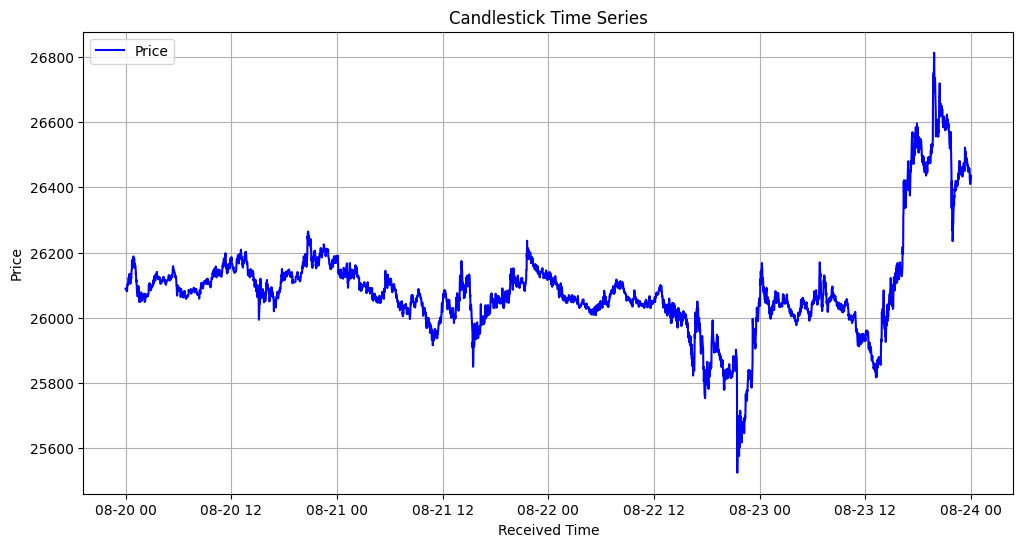

In [2]:
import lakeapi
import datetime
import pandas as pd
from decimal import Decimal
from typing import List
import matplotlib.pyplot as plt

lakeapi.use_sample_data(anonymous_access=True)

# Configuration
SYMBOL = "BTC-USDT"
VENUE = "BINANCE"
START_DATE = datetime.datetime(2023, 8, 20)
END_DATE = datetime.datetime(2023, 8, 24)

# Download data from LakeAPI
print(f"Downloading data from LakeAPI for {SYMBOL} on {VENUE}...")

# 2. Get candle data for strategy signals
candles = lakeapi.load_data(
    table="candles",
    start=START_DATE,
    end=END_DATE,
    symbols=[SYMBOL],
    exchanges=[VENUE],
)
candles.set_index('received_time', inplace=True)
print_data_stats(candles)
display(candles.head())

# Plot time series
plt.figure(figsize=(12, 6))
plt.plot(candles.index, candles['close'], label='Price', color='blue')

# Formatting the plot
plt.xlabel("Received Time")
plt.ylabel("Price")
plt.title("Candlestick Time Series")
plt.legend()
plt.grid()

# Show the plot
plt.show()

In [3]:
# NautilusTrader imports
import nautilus_trader as nt
from nautilus_trader.model.objects import Price, Quantity
from nautilus_trader.model.identifiers import InstrumentId, StrategyId, TraderId
from nautilus_trader.model.data import BarType, Bar, TradeTick
from nautilus_trader.model.currencies import USD
from nautilus_trader.model.enums import BarAggregation, PriceType
from nautilus_trader.trading.strategy import Strategy
from nautilus_trader.persistence.wranglers import TradeTickDataWrangler, BarDataWrangler
from nautilus_trader.test_kit.providers import TestDataProvider
from nautilus_trader.test_kit.providers import TestInstrumentProvider
from nautilus_trader.backtest.engine import BacktestEngine
from nautilus_trader.backtest.engine import BacktestEngineConfig
from nautilus_trader.examples.strategies.ema_cross_twap import EMACrossTWAP
from nautilus_trader.examples.strategies.ema_cross_twap import EMACrossTWAPConfig
from nautilus_trader.examples.algorithms.twap import TWAPExecAlgorithm
from nautilus_trader.model import BarType
from nautilus_trader.model import Money
from nautilus_trader.model import TraderId
from nautilus_trader.model import Venue
from nautilus_trader.model.currencies import BTC
from nautilus_trader.model.currencies import USDT
from nautilus_trader.model.enums import AccountType
from nautilus_trader.model.enums import OmsType
from pathlib import Path
from nautilus_trader.persistence.catalog import ParquetDataCatalog


Nautilus can use raw DataFrames, but sometimes they need to be exactly matching its requirements, including the column order. This is to appease BarDataWrangler

In [4]:

def normalize_dataframe_for_nautilus(df: pd.DataFrame) -> pd.DataFrame:
    """Normalize the DataFrame to match NautilusTrader's expected format."""
    normalized = df.copy()
    # Rename columns to match NautilusTrader's expected format
    # Expects columns ['open', 'high', 'low', 'close', 'volume'] with 'timestamp' index.
    column_map = {
        'Open': 'open',
        'High': 'high',
        'Low': 'low',
        'Close': 'close',
        'Volume': 'volume',
    }
    normalized = normalized.rename(columns=column_map)
    # Ensure correct order
    normalized = normalized[['open', 'high', 'low', 'close', 'volume']]
    # Set index name to 'timestamp'
    normalized.index.name = 'timestamp'
    return normalized


First, use its low-level API to perform the backtest on data converted from LakeAPI

In [5]:
# Initialize the instrument which matches the data
instrument = TestInstrumentProvider.btcusdt_binance()

bar_type = BarType.from_str("BTCUSDT.BINANCE-1-MINUTE-LAST-EXTERNAL")
# Process into Nautilus objects
wrangler = BarDataWrangler(instrument=instrument, bar_type=bar_type)
bars = wrangler.process(normalize_dataframe_for_nautilus(candles))

# Configure backtest engine
config = BacktestEngineConfig(trader_id=TraderId("BACKTESTER-001"))

# Build the backtest engine
engine = nt.backtest.engine.BacktestEngine(config=config)

# Configure your strategy
strategy_config = EMACrossTWAPConfig(
    instrument_id=instrument.id,
    bar_type=bar_type,
    trade_size=Decimal("0.5"),
    fast_ema_period=10,
    slow_ema_period=50,
    twap_horizon_secs=10.0,
    twap_interval_secs=10.0,
)

# Add a trading venue (multiple venues possible)
venue_config = nt.backtest.config.BacktestVenueConfig(
    name="BINANCE",
    oms_type=OmsType.NETTING,
    account_type=AccountType.CASH,  # Spot CASH account (not for perpetuals or futures)
    base_currency=None,  # Multi-currency account
    starting_balances=[Money(20_000.0, USDT), Money(1, BTC)],
)

# Starting portfolio value in terms of USDT and BTC
start_portfolio_usdt_value = sum([balance.as_double() if balance.currency.code == 'USDT' 
                       else balance.as_double() * candles['open'].iloc[0] 
                       for balance in venue_config.starting_balances])
start_portfolio_btc_value = start_portfolio_usdt_value / candles['open'].iloc[0]

engine.add_venue(venue=Venue(venue_config.name), oms_type=venue_config.oms_type, 
                 account_type=venue_config.account_type, starting_balances=venue_config.starting_balances)
    # Add instrument(s)
engine.add_instrument(instrument)

# Add data
engine.add_data(bars)

# Instantiate and add your strategy
strategy = EMACrossTWAP(config=strategy_config)
engine.add_strategy(strategy=strategy)

# Instantiate and add your execution algorithm
exec_algorithm = TWAPExecAlgorithm()  # Using defaults
engine.add_exec_algorithm(exec_algorithm)

# Run the engine (from start to end of data)
result = engine.run()

print("Backtest completed.")


Backtest completed.


Note the first row of the positions report. It appears legit, but it's the only row that hasn't rounded its avg_px_close. This transaction seems to cause trouble later.

In [6]:

positions = engine.trader.generate_positions_report()
positions = positions[positions['opening_order_id'] >= 'O-20230820-192400-001-000-61']
display(positions[['opening_order_id', 'closing_order_id', 'entry', 'peak_qty', 'avg_px_close', 'realized_return', 'realized_pnl']]) 

,opening_order_id,closing_order_id,entry,peak_qty,avg_px_close,realized_return,realized_pnl
position_id,,,,,,,
BTCUSDT.BINANCE-EMACrossTWAP-000-045f2b93-fa93-4bb8-94df-064c3742ac33,O-20230820-192400-001-000-61,O-20230820-194300-001-000-62,BUY,0.500000,26122.019899,-0.00011,-27.54349042 USDT
BTCUSDT.BINANCE-EMACrossTWAP-000-c6b7dbdb-45de-4ba8-b373-28ae2123b8f9,O-20230820-194400-001-000-64,O-20230820-195500-001-000-65,SELL,0.500000,26132.270000,-0.00038,-31.11728000 USDT
BTCUSDT.BINANCE-EMACrossTWAP-000,O-20230820-195500-001-000-66,O-20230820-195500-001-000-67,BUY,0.500000,26132.270000,0.00000,-26.13227000 USDT


Note the sixth row in the `generate_account_report()` results. 0.5 BTC has disappeared, but USDT rose only by a tiny, non-sensical amount. The overall portfolio value dropped for no reason I can fathom, seems like the proceeds from the BTC sale disappeared.

Also note there are some fractional BTC on that row, disappearing immediately after. No other rows have them. These rows correspond to the above suspicious transaction.

In [7]:
raw_report = engine.trader.generate_account_report(Venue(venue_config.name))
raw_report.index = raw_report.index.tz_localize(None)  # Ensure the index is in UTC
display(raw_report[raw_report.index >= datetime.datetime(2023, 8, 20, 19, 24)][['total', 'currency']])  # Filter to show only relevant dates

,total,currency
2023-08-20 19:24:00,19137.76096500,USDT
2023-08-20 19:24:00,1.00000000,BTC
2023-08-20 19:24:00,6062.26853500,USDT
2023-08-20 19:24:00,1.50000000,BTC
2023-08-20 19:43:00,6181.17719777,USDT
2023-08-20 19:43:00,1.00504700,BTC
2023-08-20 19:43:00,6312.88314446,USDT
2023-08-20 19:43:00,1.00000000,BTC
2023-08-20 19:43:00,6312.88314446,USDT
2023-08-20 19:43:00,1.00000000,BTC


In [8]:
import pandas as pd
import numpy as np
import quantstats as qs
import matplotlib.pyplot as plt

# First, make sure we have the price data needed for conversion
# We can extract the BTC/USDT price from your candles dataframe
btc_usdt_price = candles['close'].copy()

# Get the account report from the engine
# display(report.head())  # Show the first few rows to verify structure

def filter_unique_currency(report_df, currency_value):
    """Filter the report DataFrame by currency and keep only rows with unique indices."""
    curr_df = report_df[report_df['currency'] == currency_value].copy()
    unique_mask = ~curr_df.index.duplicated(keep=False)
    return curr_df[unique_mask]

btc_report = filter_unique_currency(raw_report, 'BTC')
usdt_report = filter_unique_currency(raw_report, 'USDT')

# Merge the two reports on the index
report = pd.merge(btc_report, usdt_report, left_index=True, right_index=True, suffixes=('_btc', '_usdt'))

# Get BTC/USDT prices at the same timestamps as our balance reports.
# Convert btc_usdt_price index to UTC to match report.index timezone.
aligned_prices = btc_usdt_price.reindex(
    index=report.index,
    method='ffill'  # Forward fill any missing price data
)

# Add BTC value converted to USDT
report['total_btc'] = report['total_btc'].astype(float)
report['total_usdt'] = report['total_usdt'].astype(float)
portfolio_usdt = report['total_btc'] * aligned_prices + report['total_usdt']

# Step 3: Calculate values to backtested portfolio and a BTC HODL benchmark
portfolio_value = portfolio_usdt.dropna()
benchmark_value = btc_usdt_price * start_portfolio_btc_value

# Create a dataframe holding both portfolio and benchmark values at 1-minute intervals
# First, create a common date range with 1-minute frequency spanning the data period
min_date = min(portfolio_value.index.min(), benchmark_value.index.min())
max_date = max(portfolio_value.index.max(), benchmark_value.index.max())
date_range = pd.date_range(min_date, max_date, freq='1min')

# Reindex both series to the common date range
portfolio_value_reindexed = portfolio_value.reindex(date_range, method='ffill')
benchmark_value_reindexed = benchmark_value.reindex(date_range, method='ffill')

# Create dataframe with both values
returns = pd.DataFrame({
    'Portfolio': portfolio_value_reindexed,
    'Benchmark': benchmark_value_reindexed
}).dropna()

# Calculate returns for both series
returns['Portfolio Returns'] = returns['Portfolio'].pct_change().dropna()
returns['Benchmark Returns'] = returns['Benchmark'].pct_change().dropna()



Show the problematic movements - see the second row with -30% portfolio loss, matching the strange movement at 19:44:00 observed also in `generate_account_report()`

In [9]:

display(returns[returns.index >= datetime.datetime(2023, 8, 20, 19, 43)][['Portfolio', 'Portfolio Returns']])  # Filter to show only relevant dates

,Portfolio,Portfolio Returns
2023-08-20 19:43:00,46162.242335,0.000000
2023-08-20 19:44:00,32422.111999,-0.297649
2023-08-20 19:45:00,32422.111999,0.000000
2023-08-20 19:46:00,32422.111999,0.000000
2023-08-20 19:47:00,32422.111999,0.000000
...,...,...
2023-08-23 23:55:00,32422.111999,0.000000
2023-08-23 23:56:00,32422.111999,0.000000
2023-08-23 23:57:00,32422.111999,0.000000
2023-08-23 23:58:00,32422.111999,0.000000


Visualize using quantstats. Note the last version doesn't work with last version of IPython, hence the hotfix instead of the official release.

<Figure size 1200x800 with 0 Axes>

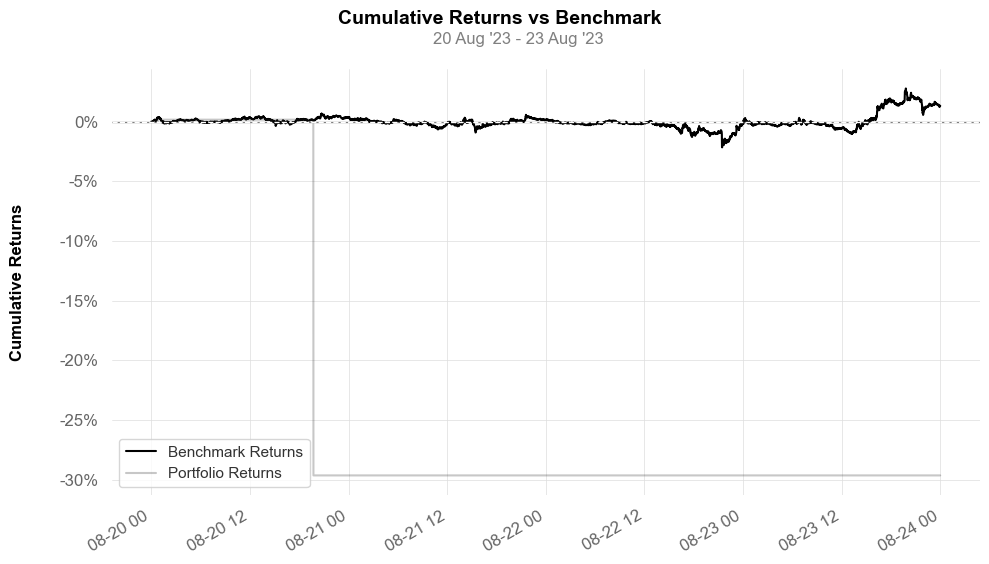


Generating QuantStats tear sheet...



C:\Users\Deirh\AppData\Roaming\Python\Python313\site-packages\quantstats\utils.py:279: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  .pct_change()
c:\Program Files\Python313\Lib\site-packages\numpy\lib\_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Program Files\Python313\Lib\site-packages\numpy\lib\_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]


ValueError: Cannot calculate a linear regression if all x values are identical

In [10]:

# Step 5: Use QuantStats to visualize the performance comparison
# Make sure QuantStats is installed: pip install quantstats
qs.extend_pandas()  # Extend pandas functionality with quantstats methods

# Plot the returns
plt.figure(figsize=(12, 8))
qs.plots.returns(returns['Portfolio Returns'], returns['Benchmark Returns'], "Strategy vs BTC/USDT")

# Generate a more comprehensive report
print("\nGenerating QuantStats tear sheet...\n")
qs.reports.metrics(returns['Portfolio Returns'], returns['Benchmark Returns'], mode='full')

# Generate a full HTML report if needed
# qs.reports.html(portfolio_returns, benchmark_returns, output='strategy_report.html', title='Strategy vs BTC/USDT')

# Display the cumulative returns chart
# qs.plots.drawdown(returns['Portfolio Returns'], returns['Benchmark Returns'], "Drawdown: Strategy vs BTC/USDT")
plt.show()